The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/tvm-0.7.dev1-cp37-cp37m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/topi-0.7.dev1-py3-none-any.whl


# Matrix Multiplication
:label:`ch_matmul_cpu`

We saw the NumPy `dot` operator nearly reaches the peak performance of our CPU (the Xeon E5-2686 v4) in :numref:`ch_cpu_arch`. In this section, we will investigate multiple scheduling strategies for this operator in TVM.

## Setup


In [1]:
%matplotlib inline
import d2ltvm
import numpy as np
import timeit
import tvm
from tvm import te

target = 'llvm -mcpu=skylake-avx512'

As we did in :numref:`ch_vector_add_cpu`, we first define a method to measure NumPy performance as our baseline.


In [2]:
# Save to the d2ltvm package.
def np_matmul_timer(n):
    timer = timeit.Timer(setup='import numpy as np\n'
                         'import d2ltvm\n'
                         'a, b, c = d2ltvm.get_abc(%s)' % str((n,n)),
                         stmt = 'np.dot(a, b, out=c)')
    return timer.timeit

sizes = 2**np.arange(5, 12, 1)
exe_times = [d2ltvm.bench_workload(np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes **3 / 1e9 / np.array(exe_times)

## Default Schedule

The default schedule consists of three nested for-loops.


In [3]:
def default(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    return te.create_schedule(C.op), (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

produce C {
  for (x, 0, 64) {
    for (y, 0, 64) {
      C[((x*64) + y)] = 0f
      for (k, 0, 64) {
        C[((x*64) + y)] = (C[((x*64) + y)] + (A[((x*64) + k)]*B[((k*64) + y)]))
      }
    }
  }
}



To benchmark its performance, we also define a reusable method as we did in :numref:`ch_vector_add_cpu`.


In [4]:
# Save to the d2ltvm package.
def bench_matmul_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, ctx=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.context(target, 0)
        a, b, c = d2ltvm.get_abc((n, n), lambda x: tvm.nd.array(x, ctx=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return 2 * sizes**3 / 1e9 / np.array(times)

The default schedule follows the computation illustrated in :numref:`fig_matmul_default`.
It's not surprising to see that the default schedule doesn't perform well, especially for large matrices that cannot fit into the cache.


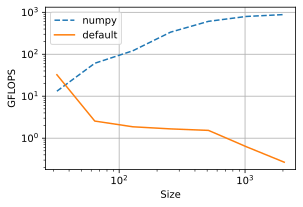

In [5]:
default_gflops = bench_matmul_tvm(default, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'default'])

## Reordering Axes

The first problem we can see from :numref:`fig_matmul_default` is that matrix $B$ is accessed column by column while its elements are stored by rows (i.e. matrix $B$ is in [row-major](https://en.wikipedia.org/wiki/Row-_and_column-major_order)). In other words, in the pseudo code above, we iterate axis `y` before axis `k`. Simply switching these two for-loops will make all elements read and written sequentially. :numref:`fig_matmul_reorder` illustrates the changed the data access pattern.

![Reorder axes in matrix multiplication.](http://tvm.d2l.ai/_images/matmul_reorder.svg)
:label:`fig_matmul_reorder`

To implement it, we change the axes order from (`x`, `y`, `k`) to (`x`, `k`, `y`) by the `reorder` primitive. The corresponding pseudo code verifies that we are processing all matrices row by row now.


In [6]:
def reorder(n):
    s, (A, B, C) = default(n)
    (x, y), (k,) = C.op.axis, C.op.reduce_axis
    s[C].reorder(x, k, y)
    return s, (A, B, C)

s, args = reorder(64)
print(tvm.lower(s, args, simple_mode=True))

produce C {
  for (x, 0, 64) {
    for (y.init, 0, 64) {
      C[((x*64) + y.init)] = 0f
    }
    for (k, 0, 64) {
      for (y, 0, 64) {
        C[((x*64) + y)] = (C[((x*64) + y)] + (A[((x*64) + k)]*B[((k*64) + y)]))
      }
    }
  }
}



We can see that the reordering significantly improves the performance compared to the default schedule.


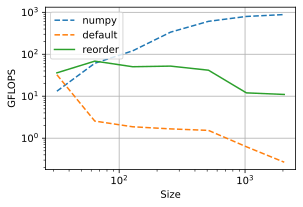

In [7]:
reorder_gflops = bench_matmul_tvm(reorder, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops],
            ['numpy', 'default', 'reorder'])

## Parallelization

Let's revisit the pseudo code above. In the outermost for-loop `for (x, 0, 64)`, each time we compute the results of a row in $C$. Each row can be computed in parallel, so we can make the schedule parallelize axis `x`.


In [8]:
def parallel(n):
    s, (A, B, C) = reorder(n)
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

produce C {
  parallel (x, 0, 64) {
    for (y.init, 0, 64) {
      C[((x*64) + y.init)] = 0f
    }
    for (k, 0, 64) {
      for (y, 0, 64) {
        C[((x*64) + y)] = (C[((x*64) + y)] + (A[((x*64) + k)]*B[((k*64) + y)]))
      }
    }
  }
}



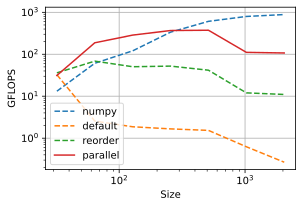

In [9]:
parallel_gflops = bench_matmul_tvm(parallel, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, reorder_gflops, parallel_gflops],
            ['numpy', 'default', 'reorder', 'parallel'])

Parallelization improves the performance again. But we can see that there is still a gap compared to NumPy on large matrices, specially when they cannot fit into the L2 cache. We will try to resolve it in the next section.

## Summary

- Reordering the for-loops in matrix multiplication properly improves the performance.
- Proper thread-level parallelization also improves the performance.

## Exercises

1. Change the number of threads
1. Try to order the axes in method `parallel` differently
1. Benchmark matrix multiplication in larger sizes
